In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Saliency computation

We will calculate the saliency for the `lena` image using the independent components gathered earlier.

In [384]:
from PIL import Image

img = Image.open("../CAT2000_train/Stimuli/Social/031.jpg")
smap = Image.open("../CAT2000_train/FIXATIONMAPS/Social/031.jpg")

img.thumbnail((512, 512))
smap.thumbnail((512, 512))

img = np.array(img)/255
smap = np.array(smap)/255

(-0.5, 511.5, 287.5, -0.5)

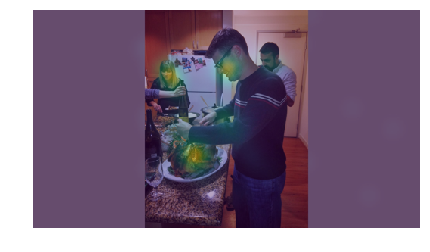

In [385]:
f = plt.figure(figsize=(8, 4))

plt.imshow(img)
plt.imshow(smap, alpha=0.4)
plt.axis("off")

#plt.savefig("experiment-smap.png")

In [4]:
from features import extract_patches, compute_saliency

Now compute the saliency using our data and the original SUN data and compare the saliency maps.

In [40]:
from scipy.io import loadmat

# Load data from original SUN paper
mat = loadmat("/Users/jesperwohlerthansen/Downloads/saliency/stats.mat")

filters = mat["B1"]
sigma = mat["sigmas"].reshape(-1)
theta = mat["thetas"].reshape(-1)

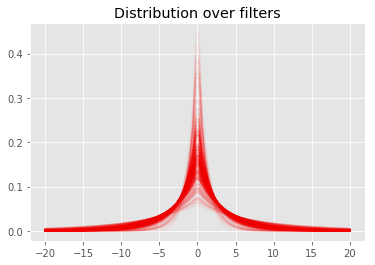

In [6]:
from scipy.stats import gennorm

x = np.linspace(-20, 20, 100)

plt.plot(x, gennorm.pdf(x.repeat(362).reshape(-1, 362), theta, loc=0, scale=sigma), alpha=0.05, c="r")
plt.title("Distribution over filters")

plt.show()

Find the theta and sigma for each filter.

In [7]:
from scipy.io import loadmat

def load_matrix(path):
    """
    Load the dataset each matrix at a time and
    combine the color changes such that (L, M, S) <-> (R, G, B)
    and all images have dimensions (250, 320).
    """
    channels = ("OL", "OM", "OS")
    image = np.dstack([loadmat(path)[c] for c in channels])
    if image.shape != (500, 640, 3):
        image = image.transpose(1, 0, 2)
    image = Image.fromarray((image*255).astype(np.uint8))
    image.thumbnail((250, 250))
    image = np.array(image)/255
    return image

base_path = "./eizaburo-doi-kyoto_natim-c2015ff/osLMS0103-{}.mat"
images = np.array([load_matrix(base_path.format(i)) for i in range(21, 35)])

In [8]:
components = np.load("filters.npy")
components -= np.mean(components, 0)

In [9]:
from features import compute_response

response, dims = compute_response(np.vstack(images), components)

In [41]:
theta_ours, sigma_ours = np.load("theta.npy"), np.load("sigma.npy")

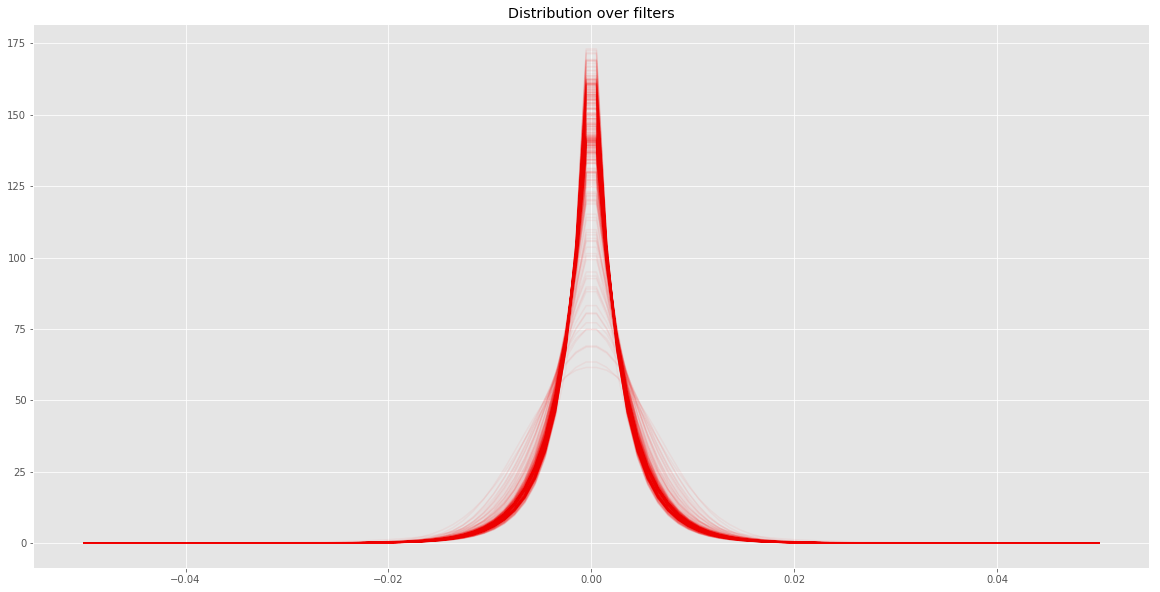

In [35]:
f = plt.figure(figsize=(20, 10))

x = np.linspace(-1/20, 1/20, 100)

plt.plot(x, gennorm.pdf(x.repeat(363).reshape(-1, 363), theta, loc=0, scale=sigma), alpha=0.05, c="r")
plt.title("Distribution over filters")

plt.savefig("filter-distribution.pdf")

In [386]:
saliency_sun = compute_saliency(img, filters)
saliency_sun_w = compute_saliency(img, filters, theta=theta, sigma=sigma)
saliency_ours = compute_saliency(img, components)
saliency_ours_w = compute_saliency(img, components, theta=theta_ours, sigma=sigma_ours)

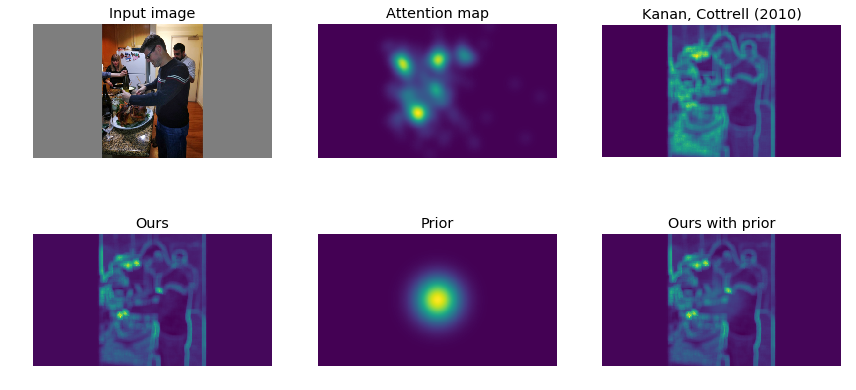

In [398]:
f, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(12, 6))

ax0.imshow(img)
ax0.set_title("Input image")
ax0.axis("off")

ax1.imshow(smap)
ax1.set_title("Attention map")
ax1.axis("off")

ax2.imshow(saliency_sun_w)
ax2.set_title("Kanan, Cottrell (2010)")
ax2.axis("off")

ax3.imshow(saliency_ours_w)
ax3.set_title("Ours")
ax3.axis("off")

ax4.imshow(a)
ax4.set_title("Prior")
ax4.axis("off")

ax5.imshow(saliency_ours_w/np.max(saliency_ours_w) + 1000*a)
ax5.set_title("Ours with prior")
ax5.axis("off")

plt.tight_layout()

#plt.savefig("comparison.pdf")

In [88]:
from scipy.stats import multivariate_normal

In [396]:
h, w = saliency_ours_w.shape

x, y = np.mgrid[0:h:1, 0:w:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

n = multivariate_normal(mean=(h//2, w//2), cov=1000*np.eye(2))
a = n.pdf(pos)

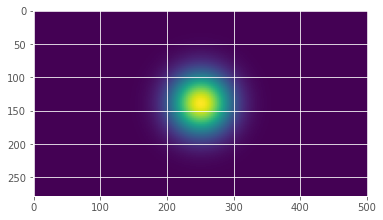

In [397]:
plt.imshow(a)

In [378]:
print(saliency_ours_w.min())
print(a.min())

56.7793542451
-1971.08648289


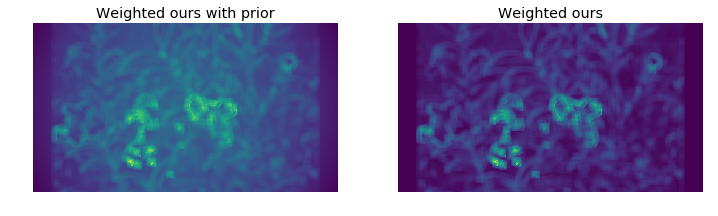

In [381]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


ax1.imshow(saliency_ours_w + 0.5*np.sum(a, 2))
ax1.set_title("Weighted ours with prior")
ax1.axis("off")

ax2.imshow(saliency_ours_w)
ax2.set_title("Weighted ours")
ax2.axis("off")

plt.show()